In [22]:
import sys,os
import uproot4 as uproot
import awkward1 as ak
import json
import numpy as np
import matplotlib.pyplot as plt
from fcc_python_tools.locations import loc
from fcc_python_tools import kinematics_flat
from particle import literals as lp
from fcc_python_tools import plotting
import tensorflow as tf
import zfit
import random

from matplotlib import rc
rc('font',**{'family':'serif','serif':['Roman']})
rc('text', usetex=True)

In [23]:
path = "/eos/experiment/fcc/ee/tmp/testmatching/"
mode = "Bs2DsK"

file = uproot.open(path+f"events_{mode}.root")
tree = file['events']
events = tree.arrays(library="ak", how="zip")

n_keep = 100000
events = events[:n_keep] 

In [24]:
rp = events["RP"]

#Pions
pi_cut = abs(rp["mass"] - lp.pi_plus.mass/1000.) < 1e-4
pions = rp[pi_cut]
p_cut = pions["p"] > 1.
pions = pions[p_cut]

#Kaons
k_cut = abs(rp["mass"] - lp.K_plus.mass/1000.) < 1e-4
kaons = rp[k_cut]
p_cut = kaons["p"] > 1.
kaons = kaons[p_cut]

Build $KK$ for $D_s$ and then $D_s$

In [25]:
kk = ak.combinations(kaons, 2)
kk["k_1"], kk["k_2"] = ak.unzip(kk)

kk_charge_cut = kk["k_1","charge"] != kk["k_2","charge"]
kk = kk[kk_charge_cut]

Ds = ak.cartesian({"kk": kk, "pi": pions})

PDG_K_m = lp.K_plus.mass/1000.
PDG_pi_m = lp.pi_plus.mass/1000.
Ds["mass"] = kinematics_flat.mass([Ds["kk","k_1"], 
                                   Ds["kk","k_2"],
                                   Ds["pi"]
                                  ], 
                                  [PDG_K_m, 
                                   PDG_K_m,
                                   PDG_pi_m
                                  ])

PDG_Ds_m = lp.D_s_plus.mass/1000.
Ds_window = 0.025
Ds_cut = abs(Ds["mass"] - PDG_Ds_m) < Ds_window
Ds = Ds[Ds_cut]

#Pion of opposite charge to one kaon
Ds_charge_cut = Ds["kk","k_1","charge"] != Ds["pi","charge"]
Ds = Ds[Ds_charge_cut]

Build $B_s^0$ from $D_s^+$ and a kaon

In [26]:
Bs = ak.cartesian({"Ds": Ds, "k": kaons})
Bs_charge_cut = Bs["Ds","pi","charge"] != Bs["k","charge"]

Bs["mass"] = kinematics_flat.mass([Bs["Ds","kk","k_1"],
                                   Bs["Ds","kk","k_2"],
                                   Bs["Ds","pi"],
                                   Bs["k"]
                                  ],
                                  [PDG_K_m,
                                   PDG_K_m,
                                   PDG_pi_m,
                                   PDG_K_m
                                  ])

Bs_mass_low = 5.3
Bs_mass_high = 5.45
Bs_mass_low_cut = Bs["mass"] >= Bs_mass_low
Bs_mass_high_cut = Bs["mass"] <= Bs_mass_high
Bs_mass_cut = np.logical_and(Bs_mass_low_cut, Bs_mass_high_cut)
Bs = Bs[Bs_mass_cut]

Fit the $B_s^0$ peak with zfit

In [27]:
low = Bs_mass_low
high = Bs_mass_high
obs = zfit.Space('mB', limits=(low, high))

#Signal PDF
rand = random.randint(0,9999)
mu = zfit.Parameter(f"mu_{rand}", lp.B_s_0.mass/1000., low, high)
sigma = zfit.Parameter(f"sigma_{rand}", 0.005, 0.0001, 0.1)
alphaL = zfit.Parameter(f"alphaL_{rand}", 0.5, 0., 5.)
nL = zfit.Parameter(f"nL_{rand}", 100., 0., 200.)
alphaR = zfit.Parameter(f"alphaR_{rand}", -0.5, -5., 0.)
nR = zfit.Parameter(f"nR_{rand}", 100., 0., 200.)
frac = zfit.Parameter(f"frac_{rand}", 0.2, 0., 1.)

pdf_sigL = zfit.pdf.CrystalBall(obs=obs, mu=mu, sigma=sigma, alpha=alphaL, n=nL)
pdf_sigR = zfit.pdf.CrystalBall(obs=obs, mu=mu, sigma=sigma, alpha=alphaR, n=nR)
pdf = zfit.pdf.SumPDF([pdf_sigL, pdf_sigR], frac)

In [28]:
data_np = ak.to_numpy(ak.flatten(Bs["mass"]))
data = zfit.Data.from_numpy(obs=obs, array=data_np)

In [29]:
nll = zfit.loss.UnbinnedNLL(model=pdf, data=data)
minimizer = zfit.minimize.Minuit()
result = minimizer.minimize(nll)
param_errors = result.hesse()

print("m(D* - D0) fit function minimum:", result.fmin)
print("m(D* - D0) fit converged:", result.converged)
print("m(D* - D0) fit full minimizer information:", result.info)

params = result.params
print(params)

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = -2.438e+04                 │       Ncalls = 717 (717 total)       │
│ EDM = 0.000115 (Goal: 0.001)     │               up = 0.5               │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│   Hesse ok    │  Has Covariance  │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
m(D* - D0) fit function minimum: -24377.12033291786
m(D* - D0) fit converged: True
m(D* - D0) fit full minimizer information: {'n_eval': 717, 'n_iter': 717, 'original': FMin(fval=-24377.12033291786, edm=0.00011504985510020483, tolerance=1.0

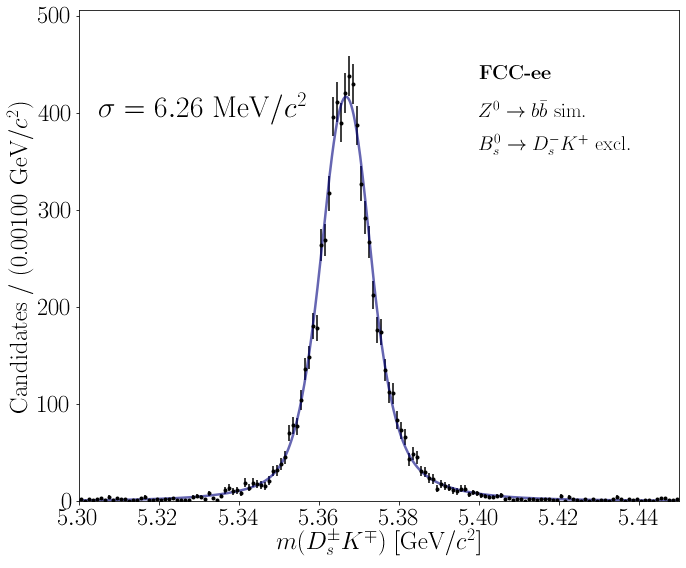

In [32]:
fig,ax = plt.subplots(figsize=(10,8))
lower, upper = obs.limits
low = lower[-1][0]
high = upper[0][0]
bin_width = 0.001
bins = int(float(high - low)/bin_width)
counts, bin_edges = np.histogram(data_np, bins, range=(low,high))
bin_centres = (bin_edges[:-1] + bin_edges[1:])/2.
err = np.sqrt(counts)
plt.errorbar(bin_centres, counts, yerr=err, fmt='o', markersize=3, color='black')
x_plot = np.linspace(low, high, num=1000)
y_plot_tot = zfit.run(pdf.pdf(x_plot, norm_range=obs))
plt.plot(x_plot, y_plot_tot*len(data_np)/bins*obs.area(), color='navy', linewidth=2.5, alpha=0.6)
ax.tick_params(axis='both', which='major', labelsize=25)
plt.ylabel("Candidates / (%.5f GeV/$c^2$)" % bin_width,fontsize=25)
plt.xlabel("$m(D_s^\\pm K^\\mp)$ [GeV/$c^2$]",fontsize=25)
plt.xlim(low,high)
ymin, ymax = plt.ylim()
plt.ylim(0,1.05*ymax)
plt.text(5.4,0.9*ymax,"\\textbf{FCC-ee}",fontsize=20)
plt.text(5.4,0.82*ymax,"$Z^0 \\to b \\bar{b}$ sim.",fontsize=20)
plt.text(5.4,0.74*ymax,"$B_s^0 \\to D_s^- K^+$ excl.",fontsize=20)
sigma_val = 1000.*params[sigma]['value']
plt.text(5.305,0.82*ymax,"$\\sigma = %.2f$ MeV/$c^2$" % sigma_val,fontsize=30)
plt.tight_layout()
fig.savefig(loc.PLOTS+f"/{mode}_Bs_M_fit.pdf")